# Train

In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import torch
from torch import nn
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn

from hython.datasets.datasets import LSTMDataset, get_dataset
from hython.trainer import train_val
from hython.sampler import SamplerBuilder, RegularIntervalDownsampler
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed

from hython.trainer import RNNTrainParams, RNNTrainer, SimpleHydroTrainer
from hython.normalizer import Normalizer


import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR 1: PROJ: proj_create_from_database: Open of /home/iferrario/.local/miniforge/envs/emulator/share/proj failed


# Settings

In [3]:
# PARAMETERS 

EXPERIMENT  = "test"

SURROGATE_INPUT = "https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_preprocessed.zarr/"

SURROGATE_MODEL_OUTPUT = f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/{EXPERIMENT}.pt"
TMP_STATS = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats"


# === FILTER ==============================================================

# train/test temporal range
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

dynamic_names = ["precip", "pet", "temp"] 

static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 

giuh_names = ['hand', 'distance_to_outlet', 'ldd', 'slope']

target_names = [ "vwc","actevap"]

 

# === MASK ========================================================================================

mask_names = ["mask_missing", "mask_lake"] # names depends on preprocessing application

# === DATASET ========================================================================================

DATASET = "LSTMDataset"

# == MODEL  ========================================================================================

# DL model hyper parameters
HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
OUTPUT_SIZE = len(target_names)
TARGET_WEIGHTS = {t:0.5 for t in target_names}

# === SAMPLER/TRAINER ===================================================================================

DOWNSAMPLING = False

SEED = 1696
EPOCHS = 50
BATCH = 256

TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = [150, 150] 
SEQ_LENGTH = 120

assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"



In [4]:
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# === READ TRAIN ===================================================================
Xd = (
    read_from_zarr(url=SURROGATE_INPUT , group="xd", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Xs = read_from_zarr(url=SURROGATE_INPUT , group="xs", multi_index="gridcell").xs.sel(
    feat=static_names
)
Y = (
    read_from_zarr(url=SURROGATE_INPUT , group="y", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .y.sel(feat=target_names)
)

SHAPE = Xd.attrs["shape"]

# === READ TEST ===================================================================

Y_test = (
    read_from_zarr(url=SURROGATE_INPUT , group="y", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .y.sel(feat=target_names)
)
Xd_test = (
    read_from_zarr(url=SURROGATE_INPUT , group="xd", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .xd.sel(feat=dynamic_names)
)

In [6]:
masks = (
    read_from_zarr(url=SURROGATE_INPUT, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

In [7]:
if DOWNSAMPLING:
   train_downsampler = RegularIntervalDownsampler(
        intervals=[3,3], origin=[0,0]
    )       
   test_downsampler = RegularIntervalDownsampler(
        intervals=[3,3], origin=[2,2]
    )
else:
    train_downsampler,test_downsampler = None,None

In [8]:
# === NORMALIZE ======================================================================

normalizer_dynamic = Normalizer(method="standardize", type="spacetime", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_xd.npy")
normalizer_static = Normalizer(method="standardize", type="space", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_xs.npy")
normalizer_target = Normalizer(method="standardize", type="spacetime", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_y.npy")


In [9]:
# === DATSET =======================================================================

train_dataset = get_dataset(DATASET)(
        Xd,
        Y,
        Xs,
        original_domain_shape=SHAPE,
        mask = masks,
        downsampler = train_downsampler,
        normalizer_dynamic = normalizer_dynamic,
        normalizer_static = normalizer_static,
        normalizer_target = normalizer_target
)
test_dataset = get_dataset(DATASET)(
        Xd_test,
        Y_test,
        Xs,
        original_domain_shape=SHAPE,
        mask = masks,
        downsampler = test_downsampler,
        normalizer_dynamic = normalizer_dynamic,
        normalizer_static = normalizer_static,
        normalizer_target = normalizer_target
)

[    0     1     2 ... 40137 40138 40139]
compute stats
write stats to /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/test_xd.npy
compute stats
write stats to /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/test_xs.npy
compute stats
write stats to /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats/test_y.npy
[    0     1     2 ... 40137 40138 40139]


In [10]:
# === SAMPLER ===================================================================


train_sampler_builder = SamplerBuilder(
    train_dataset,
    sampling="random", 
    processing="single-gpu")

test_sampler_builder = SamplerBuilder(
    test_dataset,
    sampling="sequential", 
    processing="single-gpu")


train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

In [11]:
# === DATA LOADER ================================================================

train_loader = DataLoader(train_dataset, batch_size=BATCH , sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH , sampler=test_sampler)

In [12]:
from hython.models.cudnnLSTM import LSTMCell, LandSurfaceModel, GIUH
from hython.trainer import RNNTrainParams, SimpleHydroTrainer

In [13]:
# Land Surface Model

land_surface_modules = nn.ModuleDict(
    {
        "vwc":LSTMCell( HIDDEN_SIZE, 3, 6, 1),
        "actevap":LSTMCell( HIDDEN_SIZE, 3, 6, 1)
    }
)


model = LandSurfaceModel(
                land_surface_modules, 
                HIDDEN_SIZE*2, # sum of all variables hidden size 
                 2 # variables
        )



In [14]:
# GIUH 

model_giuh = GIUH(
     hidden_size = giuh_hidden_size,
     dynamic_input_size = giuh_dynamic_input_size, # forcing + state_and_flux
     static_input_size = giuh_static_input_size, 
     output_size = giuh_output_size
        )

NameError: name 'giuh_hidden_size' is not defined

In [ ]:
# the dataloader should not have only the effective parameters but also the static ones for the GIUH

In [15]:
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

In [16]:
loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)
metric_fn = MSEMetric(target_names=target_names)

In [17]:
trainer = RNNTrainer(
    RNNTrainParams(
               experiment=EXPERIMENT, 
               temporal_subsampling=TEMPORAL_SUBSAMPLING, 
               temporal_subset=TEMPORAL_SUBSET, 
               seq_length=SEQ_LENGTH, 
               target_names=target_names,
               metric_func=metric_fn,
               loss_func=loss_fn)
)

In [ ]:
# train
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    test_loader,
    EPOCHS,
    opt,
    lr_scheduler,
    SURROGATE_MODEL_OUTPUT,
    device
)

  2%|█▉                                                                                               | 1/50 [01:03<51:35, 63.16s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.13192692399024963
val loss: 0.14283297955989838


  4%|███▉                                                                                             | 2/50 [02:07<50:56, 63.68s/it]

train loss: 0.1006297916173935
val loss: 0.15121707320213318


  6%|█████▊                                                                                           | 3/50 [03:08<49:07, 62.72s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.10075044631958008
val loss: 0.14019303023815155


  8%|███████▊                                                                                         | 4/50 [04:12<48:30, 63.27s/it]

train loss: 0.09399404376745224
val loss: 0.14169831573963165


 10%|█████████▋                                                                                       | 5/50 [05:14<47:07, 62.83s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.09106142818927765
val loss: 0.139723002910614


 12%|███████████▋                                                                                     | 6/50 [06:19<46:37, 63.57s/it]

train loss: 0.08695613592863083
val loss: 0.15121711790561676


 14%|█████████████▌                                                                                   | 7/50 [07:23<45:36, 63.64s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.08888477087020874
val loss: 0.13580133020877838


 16%|███████████████▌                                                                                 | 8/50 [08:26<44:23, 63.41s/it]

train loss: 0.09103836119174957
val loss: 0.14123739302158356


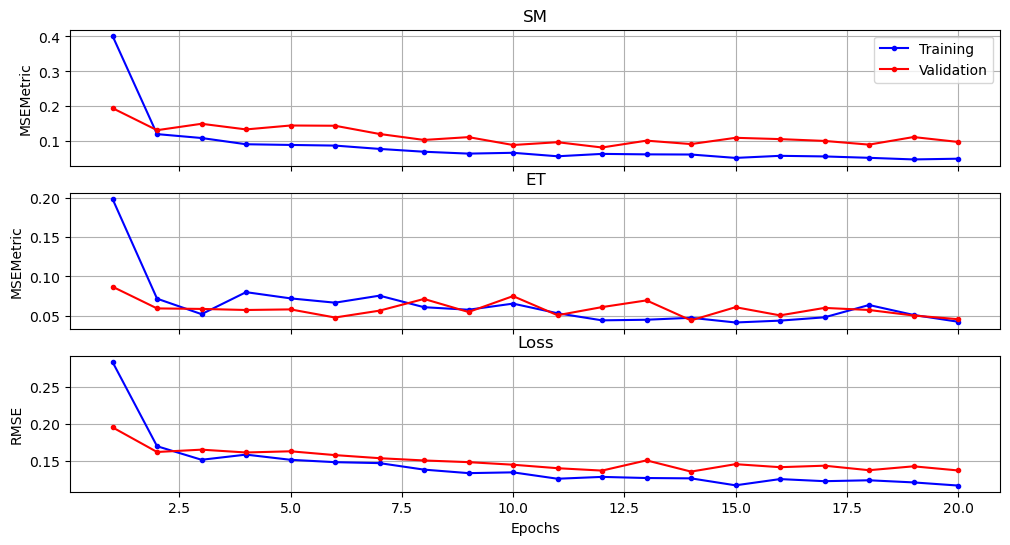

In [88]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('SM')
axs[0].set_ylabel(metric_fn.__class__.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
axs[1].set_title('ET')
axs[1].set_ylabel(metric_fn.__class__.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[2].set_title('Loss')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)